In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("D:\\Sales Forecasting System\\Data\\processed\\feature_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,lag_1,lag_4,lag_12,rolling_mean_4
0,1,2010-04-30,1425100.71,0,67.41,2.780,210.389546,7.808,1391256.12,1594968.28,1643690.90,1.499425e+06
1,1,2010-05-07,1603955.12,0,72.55,2.835,210.339968,7.808,1425100.71,1545418.53,1641957.44,1.456958e+06
2,1,2010-05-14,1494251.50,0,74.78,2.854,210.337426,7.808,1603955.12,1466058.28,1611968.17,1.471593e+06
3,1,2010-05-21,1399662.07,0,76.44,2.826,210.617093,7.808,1494251.50,1391256.12,1409727.59,1.478641e+06
4,1,2010-05-28,1432069.95,0,80.44,2.759,210.896761,7.808,1399662.07,1425100.71,1554806.68,1.480742e+06


In [3]:
train = df[df['Date'] < "2012-01-01"].copy()
test  = df[df['Date'] >= "2012-01-01"].copy()

print(train.shape, test.shape)


(3960, 12) (1935, 12)


In [4]:
FEATURES = [
    'Holiday_Flag',
    'Temperature',
    'Fuel_Price',
    'CPI',
    'Unemployment',
    'lag_1',
    'lag_4',
    'lag_12',
    'rolling_mean_4'
]

TARGET = 'Weekly_Sales'


In [5]:
from sklearn.metrics import mean_absolute_error

test['Baseline_Pred'] = test['lag_1']

baseline_mae = mean_absolute_error(
    test[TARGET],
    test['Baseline_Pred']
)

print("Baseline MAE:", baseline_mae)


Baseline MAE: 60095.495829457366


In [6]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

model.fit(train[FEATURES], train[TARGET])


RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [7]:
# Predictions
test['Model_Pred'] = model.predict(test[FEATURES])

model_mae = mean_absolute_error(
    test[TARGET],
    test['Model_Pred']
)

print("Model MAE:", model_mae)


Model MAE: 64816.63614812162


In [8]:
importance = pd.Series(
    model.feature_importances_,  #Reducing prediction error
    index=FEATURES
).sort_values(ascending=False)

importance


rolling_mean_4    0.775936
lag_1             0.142381
lag_4             0.053189
lag_12            0.009272
Holiday_Flag      0.007374
Temperature       0.005807
CPI               0.002375
Unemployment      0.002236
Fuel_Price        0.001430
dtype: float64

In [9]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(train[FEATURES], train[TARGET])

lr_pred = lr.predict(test[FEATURES])

lr_mae = mean_absolute_error(test[TARGET], lr_pred)
print("Linear Regression MAE:", lr_mae)


Linear Regression MAE: 71278.21215898948


In [10]:
import joblib
import os

model_path = r"D:\Sales Forecasting System\Models\sales_rf_model.pkl"

os.makedirs(r"D:\Sales Forecasting System\Models", exist_ok=True)

joblib.dump(model, model_path)

print(f" Model saved successfully at {model_path}")


 Model saved successfully at D:\Sales Forecasting System\Models\sales_rf_model.pkl


In [11]:
output = test[['Date', 'Store', 'Weekly_Sales', 'Model_Pred']]
output.to_csv(r"D:\Sales Forecasting System\Data\processed\model_results.csv", index=False)


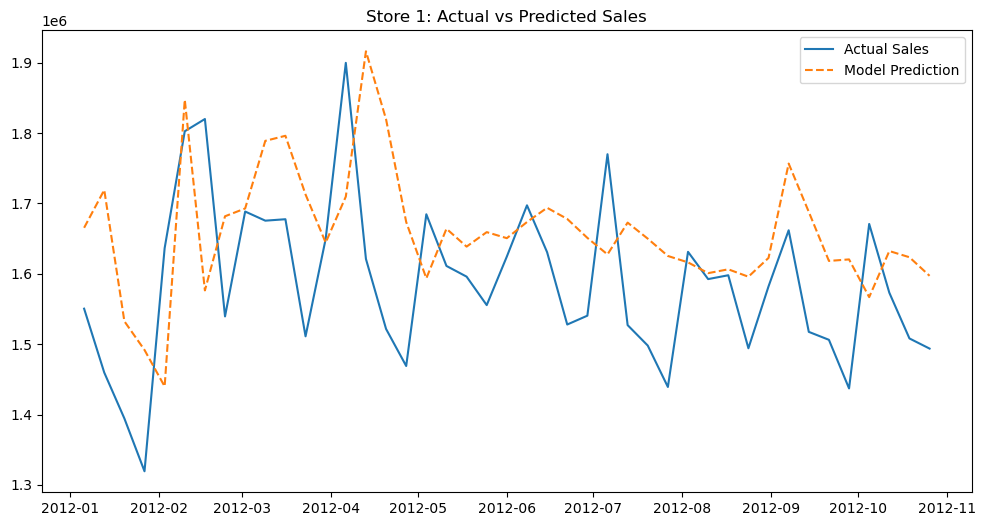

In [12]:
import matplotlib.pyplot as plt

sample_store = output[output['Store'] == 1]

plt.figure(figsize=(12, 6))
plt.plot(sample_store['Date'], sample_store['Weekly_Sales'], label='Actual Sales')
plt.plot(sample_store['Date'], sample_store['Model_Pred'], label='Model Prediction', linestyle='--')
plt.title('Store 1: Actual vs Predicted Sales')
plt.legend()
plt.show()